In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from sklearn import datasets

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = datasets.load_boston()
X = torch.tensor(data['data'], dtype=torch.float32)
y = torch.tensor(data['target'], dtype=torch.float32)
N, F = X.shape

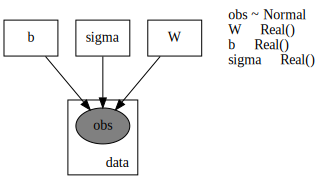

In [4]:
class FrequentistModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroParam(torch.randn(F))
        self.b = pyro.nn.PyroParam(torch.ones(1))
        self.sigma = pyro.nn.PyroParam(torch.ones(1), constraint=constraints.positive)

    def forward(self, X, y=None):
        mean = X @ self.W + self.b

        with pyro.plate("data", len(X)):
            return pyro.sample("obs", dist.Normal(mean, self.sigma), obs=y)

model = FrequentistModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [5]:
for i in range(3):
    print(model(X)[:5])

tensor([493.9527, 496.8297, 466.1495, 441.6432, 458.4671],
       grad_fn=<SliceBackward0>)
tensor([494.2658, 497.5601, 467.6973, 441.1282, 456.8084],
       grad_fn=<SliceBackward0>)
tensor([492.8128, 500.3745, 465.7054, 442.6960, 456.9063],
       grad_fn=<SliceBackward0>)


In [6]:
dist.Normal(0, 1).expand([F]).sample()

tensor([ 1.3194,  0.0873,  0.6373,  0.3866, -0.4538, -1.3786, -0.5047,  0.9853,
        -0.0128,  0.6883, -0.1746,  0.0114, -0.4353])

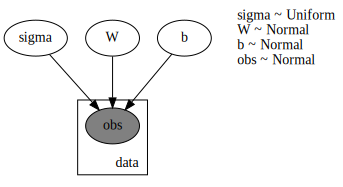

In [7]:
class BayesianModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroSample(dist.Normal(0, 10).expand([F]).to_event(1))
        self.b = pyro.nn.PyroSample(dist.Normal(20, 10))
        self.sigma = pyro.nn.PyroSample(dist.Uniform(0, 10))

    def forward(self, X, y=None):
        sigma = self.sigma   
        mean = X @ self.W + self.b
        
        with pyro.plate("data", N):
            return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

model = BayesianModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [8]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

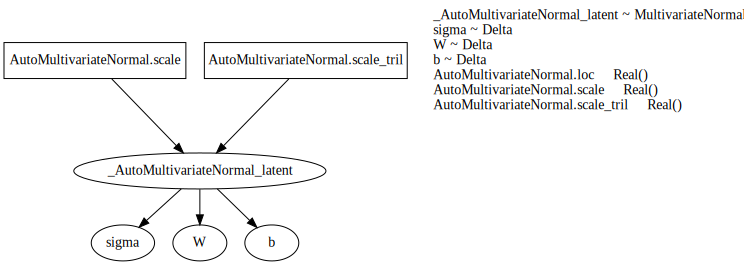

In [9]:
pyro.render_model(guide, model_args=(X, y), render_distributions=True, render_params=True)

In [10]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title(f'Min loss: {min(losses)}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

In [11]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

losses = []
for i in range(10_000):
    loss = svi.step(X, y)
    losses.append(loss)

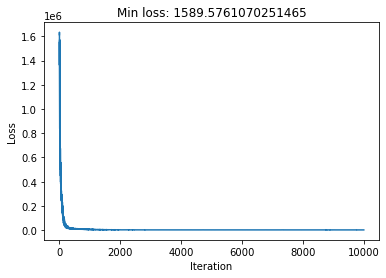

In [12]:
plot_losses(losses)

In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

W [-1.8264285   0.19136263  0.10507364 -0.077482   -0.26184654 -1.0678535
  1.0877823  -1.1289265  -1.8249459   0.2132396   0.3613377   0.89362895
  1.5309507 ]
b [1.]
sigma [1.]
AutoMultivariateNormal.loc [ 4.4614372e-01 -8.6509757e-02  4.6185233e-02 -2.2593837e-02
  2.6559093e+00 -5.4620986e+00  4.4198031e+00 -7.7379467e-03
 -1.2014892e+00  2.3987915e-01 -1.3724426e-02 -6.5063983e-01
  9.4412090e-03 -5.0594223e-01  1.9439346e+01]
AutoMultivariateNormal.scale [0.10198498 0.03677494 0.01467176 0.03643138 0.9291396  0.85304767
 0.05452259 0.00773313 0.05845299 0.02482987 0.00328094 0.02153962
 0.00284896 0.01817556 0.19922952]
AutoMultivariateNormal.scale_tril [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.30992964e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00

In [14]:
with pyro.plate('samples', 1_000, dim=-1):
    samples = guide(X)

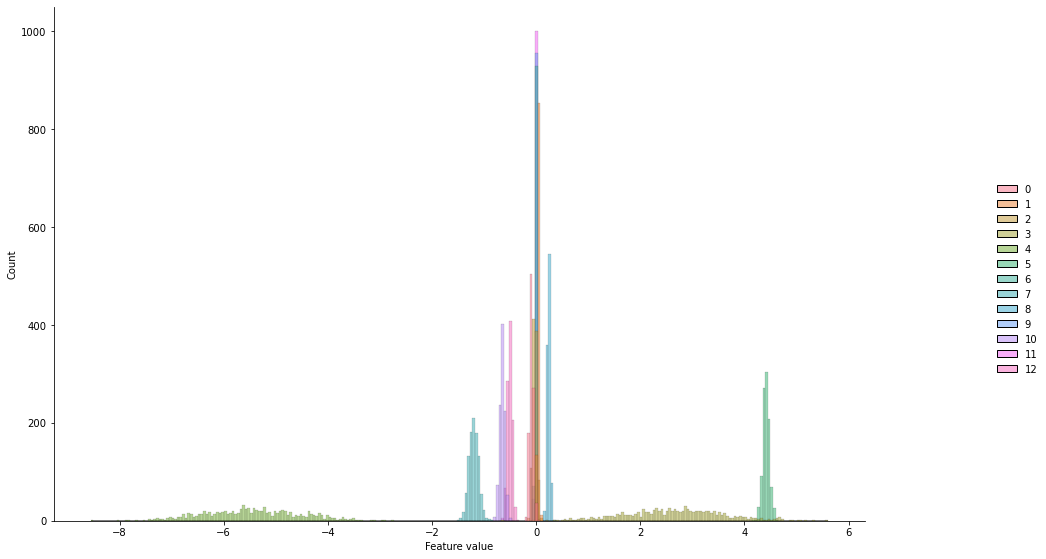

In [15]:
import seaborn as sns
g = sns.displot(samples['W'].detach().numpy())
g.fig.set_figheight(8)
g.fig.set_figwidth(16)
plt.xlabel('Feature value');

In [16]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)
svi_samples = predictive(X)
svi_y = svi_samples["obs"]

In [17]:
svi_y.shape

torch.Size([1000, 506])

In [18]:
# model.eval()
# torch.jit.trace(model, X)

In [19]:
# ws = []
# for i in range(10000):
#     ws.append(model.W)

In [20]:
# print(sum(ws) / len(ws))

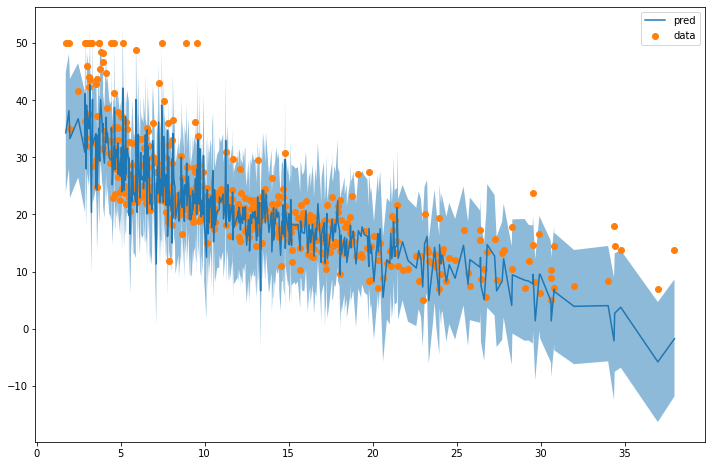

In [21]:
import pandas as pd
preds = pd.DataFrame({
    'X': X[:, -1],
    'y_mean': svi_y.mean(0).detach().cpu().numpy(),
    'y_perc_5': svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
    'y_perc_95': svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
    'true_y': y,
})
preds = preds.sort_values('X')

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(preds['X'], preds['y_mean'], label='pred')
ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
ax.scatter(preds['X'], preds['true_y'], label='data')
ax.legend();

In [22]:
X.shape

torch.Size([506, 13])

In [23]:
svi_y.shape

torch.Size([1000, 506])

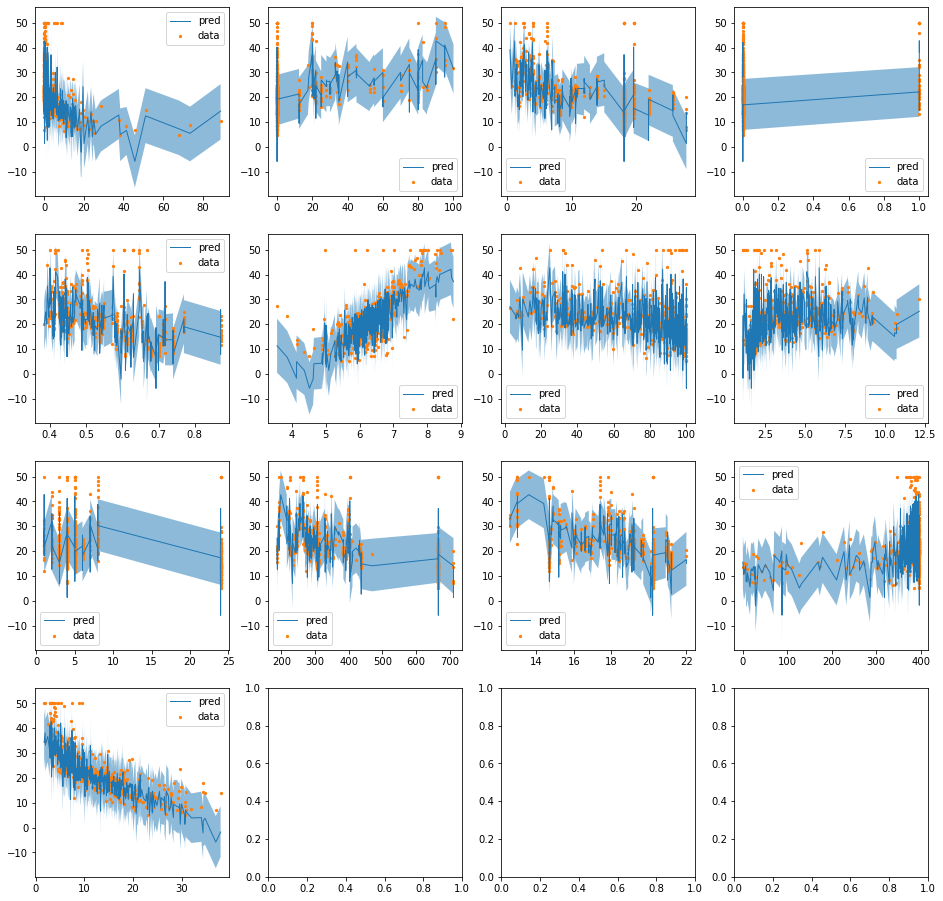

In [24]:
import pandas as pd

fig, axes = plt.subplots(4, 4, figsize=(16,16))
for i in range(F):
    preds = pd.DataFrame({
        'X': X[:, i],
        'y_mean': svi_y.mean(0).detach().cpu().numpy(),
        'y_perc_5': svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
        'y_perc_95': svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
        'true_y': y,
    })
    preds = preds.sort_values('X')

    ax = axes[i // 4][i % 4]
    ax.plot(preds['X'], preds['y_mean'], linewidth=1, label='pred')
    ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
    ax.scatter(preds['X'], preds['true_y'], s=5, label='data')
    ax.legend();